# FHE libraries benchmarking

We will be comparing [Concrete](https://docs.zama.ai/concrete) and [OpenFHE](https://github.com/openfheorg/openfhe-python) in speed over four categories:
- encryption
- addition
- multiplication
- decryption

We will run these programs for a wide range of values. For each value, we will average ten runs to remove statistical randomness, though we do not know if ten runs is sufficient.

## Encryption, Concrete

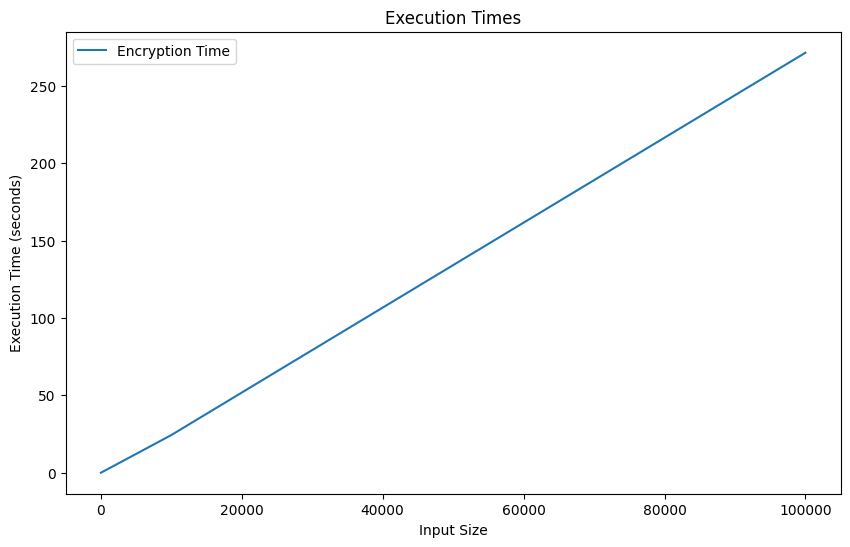

In [5]:
import time
import matplotlib.pyplot as plt
from random import randint
from typing import List, Final, Tuple
from concrete import fhe

def add(x: int, y: int) -> int:
    return x + y

num_runs: Final[int] = 1
encryption_execution_times: List[float] = []
input_sizes: List[int] = [10, 100, 1000, 10000, 100000]

compiler = fhe.Compiler(add, {"x": "encrypted", "y": "encrypted"})

for size in input_sizes:
    total_time: float = 0
    for _ in range(num_runs):
        inputset: List[Tuple[int, int]] = [(randint(0, size), randint(0, size)) for _ in range(size)]
        circuit = compiler.compile(inputset)
        start_time: float = time.time()
        for input in inputset:
            circuit.encrypt(input[0], input[1])
        end_time: float = time.time()
        execution_time = end_time - start_time
        total_time += execution_time

    average_time = total_time / num_runs
    encryption_execution_times.append(average_time)

# Plot the charts
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, encryption_execution_times, label='Encryption Time')
plt.xlabel('Input Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Times')
plt.legend()
plt.show()

# Addition, Concrete

In [ ]:
addition_execution_times: List[float] = []

for size in input_sizes:
    total_time: float = 0
    for _ in range(num_runs):
        inputset: List[Tuple[int, int]] = [(randint(0, size), randint(0, size)) for _ in range(size)]
        circuit = compiler.compile(inputset)
        encrypted_inputs = [circuit.encrypt(input[0], input[1]) for input in inputset]
        start_time: float = time.time()
        for encrypted_input in encrypted_inputs:
            circuit.run(encrypted_input)
        end_time: float = time.time()
        execution_time = end_time - start_time
        total_time += execution_time

    average_time = total_time / num_runs
    addition_execution_times.append(average_time)

# Plot the charts
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, addition_execution_times, label='Addition Time')
plt.xlabel('Input Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Times')
plt.legend()
plt.show()


# Encryption, OpenFHE

In [ ]:
# Initial Settings
from openfhe import PKESchemeFeature, CCParamsBFVRNS, GenCryptoContext

# import openfhe.PKESchemeFeature as Feature


def main():
    # Sample Program: Step 1: Set CryptoContext
    parameters = CCParamsBFVRNS()
    parameters.SetPlaintextModulus(65537)
    parameters.SetMultiplicativeDepth(2)

    crypto_context = GenCryptoContext(parameters)
    # Enable features that you wish to use
    crypto_context.Enable(PKESchemeFeature.PKE)
    crypto_context.Enable(PKESchemeFeature.KEYSWITCH)
    crypto_context.Enable(PKESchemeFeature.LEVELEDSHE)

    # Sample Program: Step 2: Key Generation

    # Generate a public/private key pair
    key_pair = crypto_context.KeyGen()

    # Generate the relinearization key
    crypto_context.EvalMultKeyGen(key_pair.secretKey)

    # Generate the rotation evaluation keys
    crypto_context.EvalRotateKeyGen(key_pair.secretKey, [1, 2, -1, -2])

    # Sample Program: Step 3: Encryption

    # First plaintext vector is encoded
    vector_of_ints1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    plaintext1 = crypto_context.MakePackedPlaintext(vector_of_ints1)

    # Second plaintext vector is encoded
    vector_of_ints2 = [3, 2, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    plaintext2 = crypto_context.MakePackedPlaintext(vector_of_ints2)

    # Third plaintext vector is encoded
    vector_of_ints3 = [1, 2, 5, 2, 5, 6, 7, 8, 9, 10, 11, 12]
    plaintext3 = crypto_context.MakePackedPlaintext(vector_of_ints3)

    # The encoded vectors are encrypted
    ciphertext1 = crypto_context.Encrypt(key_pair.publicKey, plaintext1)
    ciphertext2 = crypto_context.Encrypt(key_pair.publicKey, plaintext2)
    ciphertext3 = crypto_context.Encrypt(key_pair.publicKey, plaintext3)

    #  Sample Program: Step 4: Evaluation

    # Homomorphic additions
    ciphertext_add12 = crypto_context.EvalAdd(ciphertext1, ciphertext2)
    ciphertext_add_result = crypto_context.EvalAdd(ciphertext_add12, ciphertext3)

    # Homomorphic Multiplication
    ciphertext_mult12 = crypto_context.EvalMult(ciphertext1, ciphertext2)
    ciphertext_mult_result = crypto_context.EvalMult(ciphertext_mult12, ciphertext3)

    # Homomorphic Rotations
    ciphertext_rot1 = crypto_context.EvalRotate(ciphertext1, 1)
    ciphertext_rot2 = crypto_context.EvalRotate(ciphertext1, 2)
    ciphertext_rot3 = crypto_context.EvalRotate(ciphertext1, -1)
    ciphertext_rot4 = crypto_context.EvalRotate(ciphertext1, -2)

    # Sample Program: Step 5: Decryption

    # Decrypt the result of additions
    plaintext_add_result = crypto_context.Decrypt(
        ciphertext_add_result, key_pair.secretKey
    )

    # Decrypt the result of multiplications
    plaintext_mult_result = crypto_context.Decrypt(
        ciphertext_mult_result, key_pair.secretKey
    )

    # Decrypt the result of rotations
    plaintextRot1 = crypto_context.Decrypt(ciphertext_rot1, key_pair.secretKey)
    plaintextRot2 = crypto_context.Decrypt(ciphertext_rot2, key_pair.secretKey)
    plaintextRot3 = crypto_context.Decrypt(ciphertext_rot3, key_pair.secretKey)
    plaintextRot4 = crypto_context.Decrypt(ciphertext_rot4, key_pair.secretKey)

    plaintextRot1.SetLength(len(vector_of_ints1))
    plaintextRot2.SetLength(len(vector_of_ints1))
    plaintextRot3.SetLength(len(vector_of_ints1))
    plaintextRot4.SetLength(len(vector_of_ints1))

    print("Plaintext #1: " + str(plaintext1))
    print("Plaintext #2: " + str(plaintext2))
    print("Plaintext #3: " + str(plaintext3))

    # Output Results
    print("\nResults of homomorphic computations")
    print("#1 + #2 + #3 = " + str(plaintext_add_result))
    print("#1 * #2 * #3 = " + str(plaintext_mult_result))
    print("Left rotation of #1 by 1 = " + str(plaintextRot1))
    print("Left rotation of #1 by 2 = " + str(plaintextRot2))
    print("Right rotation of #1 by 1 = " + str(plaintextRot3))
    print("Right rotation of #1 by 2 = " + str(plaintextRot4))


if __name__ == "__main__":
    main()